<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lvm/vae_mnist_2d_foster_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder using convolutional encoder/decoder


Code uses TF 2.0 idioms and should work with images of any size and number of channels. Code is based on various sources, including
- https://www.tensorflow.org/beta/tutorials/generative/cvae.
- https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb





## Import TensorFlow and other libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## Load the dataset


In [4]:
dataname = 'mnist' 
#dataname = 'fashion_mnist'
#dataname = 'cifar10' # https://www.tensorflow.org/datasets/catalog/cifar10

# Useful pre-processing functions
#https://github.com/google/compare_gan/blob/master/compare_gan/datasets.py
  
datasets, datasets_info = tfds.load(name=dataname, with_info=True, as_supervised=False)
print(datasets_info)

input_shape = datasets_info.features['image'].shape
print(input_shape)
num_colors = input_shape[2]

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

(28, 28, 1)


In [0]:
batchsize = 64
# We assume the dataset has a dict of features called image and label.
# We extract the image from the dict, and scale each channel to [0,1]
# We return a tuple (rescaled-image, label).
def scale_pixels(sample):
  img = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  label = sample['label']
  return img, label

def scale_pixels_and_drop_label(sample):
  img = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  return img
  
drop_label = True
if drop_label:
  preprocess = scale_pixels_and_drop_label
else:
  preprocess = scale_pixels
  
def preprocess_celeba(features):
    """Returns 64x64x3 image and constant label."""
    image = features["image"]
    image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
    # Note: possibly consider using NumPy's imresize(image, (64, 64))
    image = tf.image.resize_images(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.constant(0, dtype=tf.int32)
    return image, label
    

train_dataset = (datasets['train']
                 .map(preprocess)
                 .batch(batchsize)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
test_dataset = (datasets['test']
                .map(preprocess)
                .batch(batchsize)
                .prefetch(tf.data.experimental.AUTOTUNE))



In [0]:
# To make it easy to perform random access to the test set,
# we convert to a vanilla numpy array
test_ds = tfds.as_numpy(datasets['test'].map(scale_pixels_and_drop_label))
L = list(test_ds) # force the generator to yield
x_test = np.stack(L, axis=0) # 10k, 28, 28, 1

def extract_label(sample):
  return sample['label']

test_ds = tfds.as_numpy(datasets['test'].map(extract_label))
L = list(test_ds) # force the generator to yield
y_test = np.stack(L, axis=0) # 10k

n_test = len(y_test)

In [7]:
# Inspect the dataset we just created
i = 0
for batch in train_dataset:
  if drop_label:
    X = batch
    print(X.shape)
  else:
    X, y = batch
    print(X.shape)
    print(y.shape)
  i += 1
  if i > 1:
    break

(64, 28, 28, 1)
(64, 28, 28, 1)


In [8]:
# extract small amount of data for testing
batch = train_dataset.take(1) # slow!!!
first_batch = list(batch)
if drop_label:
  X = first_batch[0]
else:
  X, y = first_batch[0]
print(X.shape) # B, H, W, C
Xsmall = X[:3, :, :, :]
print(Xsmall.shape)

(64, 28, 28, 1)
(2, 28, 28, 1)


# Define model

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [0]:
def make_encoder(
        input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
  encoder_input = Input(shape=input_dim, name='encoder_input')
  x = encoder_input
  n_layers_encoder = len(encoder_conv_filters)
  for i in range(n_layers_encoder):
      conv_layer = Conv2D(
          filters = encoder_conv_filters[i]
          , kernel_size = encoder_conv_kernel_size[i]
          , strides = encoder_conv_strides[i]
          , padding = 'same'
          , name = 'encoder_conv_' + str(i)
          )
      x = conv_layer(x)
      if use_batch_norm:
          x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      if use_dropout:
          x = Dropout(rate = 0.25)(x)
  shape_before_flattening = K.int_shape(x)[1:]
  x = Flatten()(x)
  mu = Dense(z_dim, name='mu')(x) # no activation
  log_var = Dense(z_dim, name='log_var')(x) # no activation
  encoder = Model(encoder_input, (mu, log_var))
  return encoder, shape_before_flattening



In [13]:
# Test
encoder, shape_before_flattening = make_encoder(
    input_dim = input_shape
    , encoder_conv_filters = [32,64]
    , encoder_conv_kernel_size = [3,3]
    , encoder_conv_strides = [2,2]
    , z_dim = 2
)
#encoder.summary()
print(shape_before_flattening)

print(Xsmall.shape)
M, V = encoder(Xsmall)
print(M.shape)
print(V.shape)

(7, 7, 64)
(2, 28, 28, 1)
(2, 2)
(2, 2)


In [0]:
def make_decoder(
        shape_before_flattening
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
  decoder_input = Input(shape=(z_dim,), name='decoder_input')
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)
  n_layers_decoder = len(decoder_conv_t_filters)
  for i in range(n_layers_decoder):
      conv_t_layer = Conv2DTranspose(
          filters = decoder_conv_t_filters[i]
          , kernel_size = decoder_conv_t_kernel_size[i]
          , strides = decoder_conv_t_strides[i]
          , padding = 'same'
          , name = 'decoder_conv_t_' + str(i)
          )
      x = conv_t_layer(x)
      if i < n_layers_decoder - 1:
          if use_batch_norm:
              x = BatchNormalization()(x)
          x = LeakyReLU()(x)
          if use_dropout:
              x = Dropout(rate = 0.25)(x)
      # No activation fn in final layer since returns logits
      #else:
      #    x = Activation('sigmoid')(x)
  decoder_output = x
  decoder = Model(decoder_input, decoder_output)
  return decoder
  


In [15]:
# Test
decoder = make_decoder(
    shape_before_flattening
    , decoder_conv_t_filters = [64,32,num_colors]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [2,2,1]
    , z_dim = 2
)
#print(decoder.summary())

Z = np.random.randn(5, 2).astype(np.float32)
Xrecon = decoder(Z)
print(Xrecon.shape)

(5, 28, 28, 1)


In [0]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def sample_gauss(mean, logvar):
  eps = tf.random.normal(shape=mean.shape)
  return eps * tf.exp(logvar * .5) + mean

In [0]:
class ConvVAE(tf.keras.Model):
  def __init__(self,
        input_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        z_dim,
        use_batch_norm = False,
        use_dropout= False,
        recon_loss_scaling = 1,
        kl_loss_scaling = 1,
        use_mse_loss = False
        ):
    super(ConvVAE, self).__init__()
    self.latent_dim = z_dim
    self.recon_loss_scaling = recon_loss_scaling
    self.kl_loss_scaling = kl_loss_scaling
    self.use_mse_loss = use_mse_loss
    self.inference_net, self.shape_before_flattening = make_encoder(
        input_dim,
        encoder_conv_filters,
        encoder_conv_kernel_size,
        encoder_conv_strides,
        z_dim,
        use_batch_norm,
        use_dropout)
    self.generative_net = make_decoder(
        self.shape_before_flattening,
        decoder_conv_t_filters,
        decoder_conv_t_kernel_size,
        decoder_conv_t_strides,
        z_dim,
        use_batch_norm,
        use_dropout)

  @tf.function
  def sample(self, nsamples=1):
    eps = tf.random.normal(shape=(nsamples, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode_stochastic(self, x):
    mean, logvar = self.inference_net(x)
    return sample_gauss(mean, logvar)

  def decode(self, z, apply_sigmoid=True):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  
  
  @tf.function
  def compute_loss(self, x):
    mean, logvar = self.inference_net(x)
    z = sample_gauss(mean, logvar)
    if self.use_mse_loss:
      x_probs = self.decode(z, apply_sigmoid=True)
      mse = tf.reduce_mean( (x - x_probs) ** 2, axis=[1, 2, 3])
      logpx_z = -0.5*mse # log exp(-0.5 (x-mu)^2)
    else:
      x_logit = self.decode(z, apply_sigmoid=False)
      cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x) # -sum_{c=0}^1 p_c log q_c
      logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # sum over H,W,C
    logpz = log_normal_pdf(z, 0., 0.) # prior: mean=0, logvar=0
    logqz_x = log_normal_pdf(z, mean, logvar)
    kl_loss = logpz - logqz_x # MC approximation
    return -tf.reduce_mean(self.recon_loss_scaling * logpx_z + self.kl_loss_scaling * kl_loss) # -ve ELBO


          
  @tf.function
  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
      loss = self.compute_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    return gradients


In [0]:

model_old = ConvVAE(
    input_dim = input_shape,
    encoder_conv_filters = [32,64],
    encoder_conv_kernel_size = [3,3],
    encoder_conv_strides = [2,2],
    decoder_conv_t_filters = [64,32,num_colors],
    decoder_conv_t_kernel_size = [3,3,3],
    decoder_conv_t_strides = [2,2,1],
    z_dim = 50
)


# Match setting from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_digits_train.ipynb
model = ConvVAE(
    input_dim = input_shape,
    encoder_conv_filters = [32,64,64, 64],
    encoder_conv_kernel_size = [3,3,3,3],
    encoder_conv_strides = [1,2,2,1],
    decoder_conv_t_filters = [64,64,32,num_colors],
    decoder_conv_t_kernel_size = [3,3,3,3],
    decoder_conv_t_strides = [1,2,2,1],
    z_dim = 2,
    recon_loss_scaling = 1000,
    use_mse_loss = True
)



In [42]:
# Test
M, V = model.inference_net(Xsmall)
print(M.shape)
print(V.shape)

Z = model.encode_stochastic(Xsmall)
print(Z.shape)

predictions = model.decode(Z)
print(Z.shape)
print(predictions.shape)


(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 28, 28, 1)


In [43]:
L = model.compute_loss(Xsmall)
print(L)
g = model.compute_gradients(Xsmall)
print(g[0].shape) # 3,3,1,32 - size of first layer conv

tf.Tensor(115.28917, shape=(), dtype=float32)
(3, 3, 1, 32)


# Training


Epoch 0, Test loss: 115.61153, time 42.00


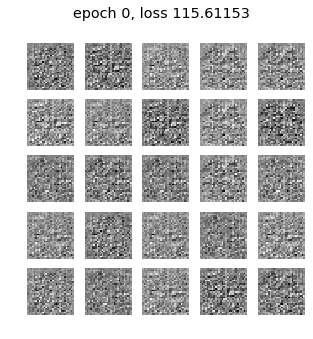

In [46]:
# Callback
def generate_images(model, epoch, noise_vector):
  predictions = model.decode(noise_vector)
  n = int(np.sqrt(num_examples_to_generate))
  fig = plt.figure(figsize=(n,n))
  for i in range(predictions.shape[0]):
      plt.subplot(n, n, i+1)
      if num_colors == 1:
         plt.imshow(predictions[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(predictions[i, :, :, :])
      plt.axis('off')
  
  
num_examples_to_generate = 25 # 16
# We use fixed noise vector to generate samples during training so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, model.latent_dim])

# we assume model.compute_loss(batch) is defined
# as well as test_dataset
def callback(model, epoch, elapsed_time):
  loss_tracker = tf.keras.metrics.Mean()
  for batch in test_dataset:
    loss_tracker(model.compute_loss(batch))
  test_loss = loss_tracker.result()
  #display.clear_output(wait=False) # don't erase old outputs
  print('Epoch {}, Test loss: {:0.5f}, time {:0.2f}'.format(
            epoch, test_loss, elapsed_time)) 
  generate_images(model, epoch, random_vector_for_generation)
  plt.suptitle('epoch {}, loss {:0.5f}'.format(epoch, test_loss), fontsize='x-large')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

  
  
# Test 
callback(model, 0, 42)

In [0]:
# generic (model agnostic) training function.
# model must support these methods:
# g = model.compute_gradients(X)
# model.traininable_variables (so model is a subclass of Keras.Model)

# Callback has following interface: callback(model, epoch, elapsed_time)

def train_model(model, optimizer, train_dataset,
                epochs, callback=None, print_every_n_epochs=1):
  for epoch in range(0, epochs):
    start_time = time.time()
    for batch in train_dataset:
      gradients = model.compute_gradients(batch)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    end_time = time.time()
    elapsed_time = end_time - start_time
    if callback:
       callback(model, epoch, elapsed_time)                               
  return model

Epoch 0, Test loss: 28.14708, time 29.55


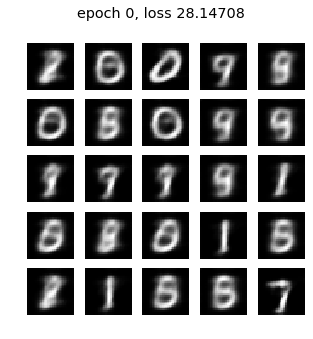

Epoch 1, Test loss: 27.57688, time 27.56


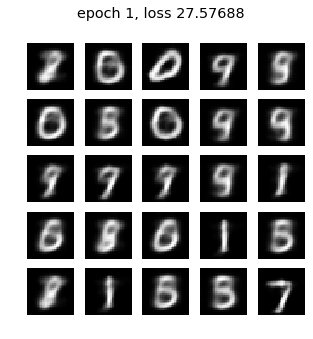

Epoch 2, Test loss: 27.38755, time 27.42


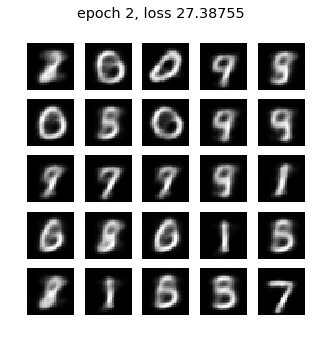

Epoch 3, Test loss: 26.95321, time 27.68


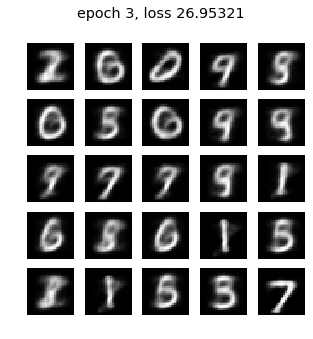

Epoch 4, Test loss: 26.75620, time 27.58


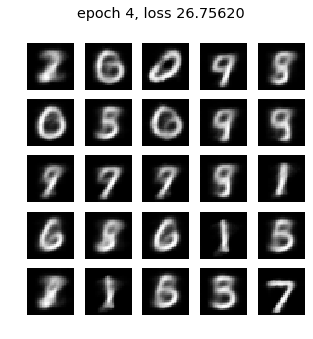

In [48]:
optimizer = tf.keras.optimizers.Adam(1e-3)
epochs = 5
model = train_model(model, optimizer, train_dataset, epochs, callback)

# Post-training

### Display images generated during training

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

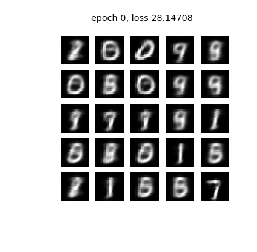

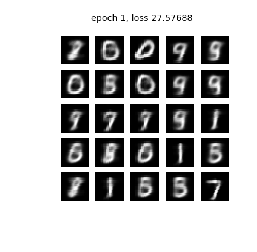

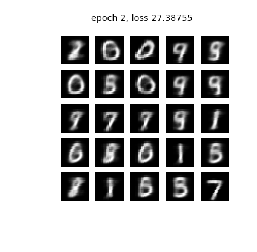

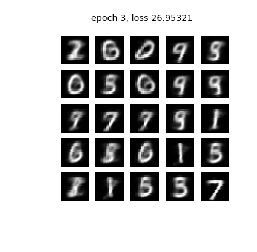

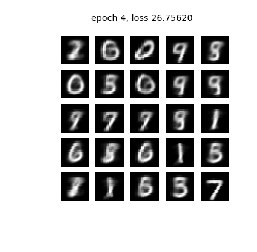

In [50]:
for i in range(epochs):
  plt.imshow(display_image(i))
  plt.axis('off')
  #plt.title('epoch {}'.format(i))
  plt.show()

In [0]:
# Make some wrapper functions

def vae_encode(model, x):
  mean, logvar = model.inference_net(x)
  return mean

def vae_decode(model, z_points):
  return model.decode(z_points)


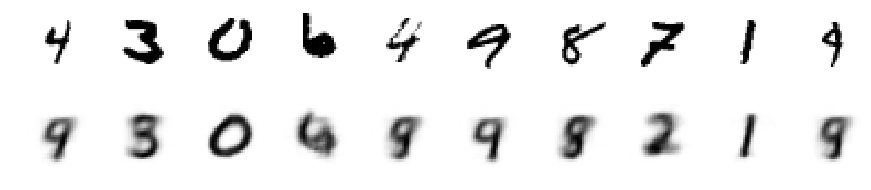

In [52]:
# Reconstruct images

n_to_show = 10
np.random.seed(42)
example_idx = np.random.choice(n_test, n_to_show)
example_images = x_test[example_idx]

z_points = vae_encode(model, example_images)
reconst_images = vae_decode(model, z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    #img = example_images[i].squeeze()
    img = example_images[i,:,:,0]
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    #sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)         
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    #img = reconst_images[i].squeeze()
    img = reconst_images[i,:,:,0]
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

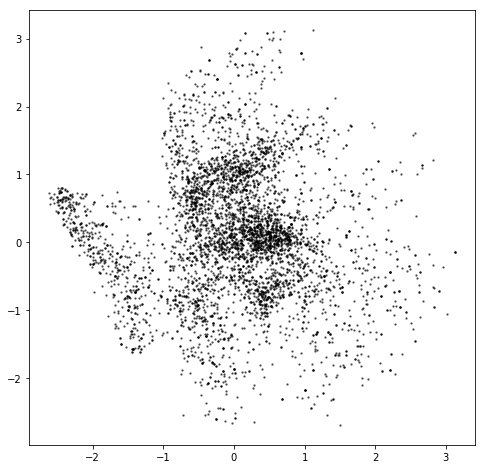

In [53]:
# Show 2d embedding of random images

n_to_show = 5000
figsize = 8
np.random.seed(42)
example_idx = np.random.choice(range(n_test), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]
z_points = vae_encode(model, example_images)


min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



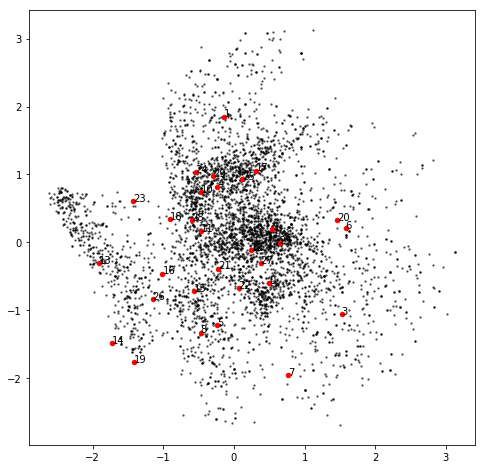

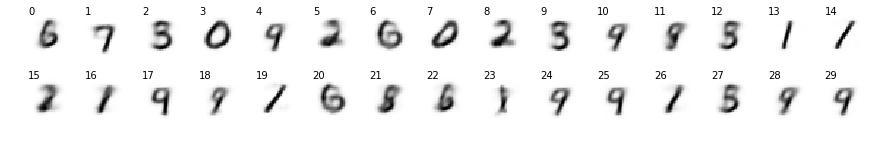

In [54]:
# generate images from random points in latent space

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

np.random.seed(42)
x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))

reconst = vae_decode(model, z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
n = np.shape(z_grid)[0]
for i in range(n):
  x = z_grid[i,0]
  y = z_grid[i,1]
  plt.text(x, y, i)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    #ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.35, str(i))
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
    

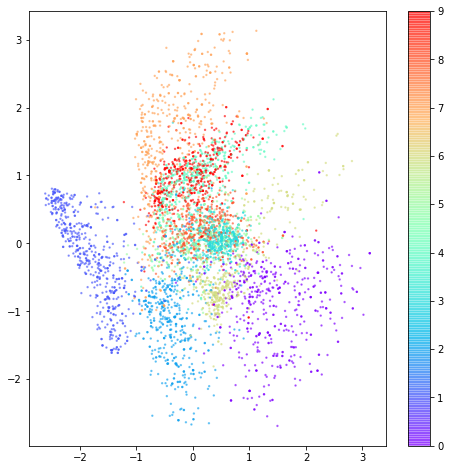

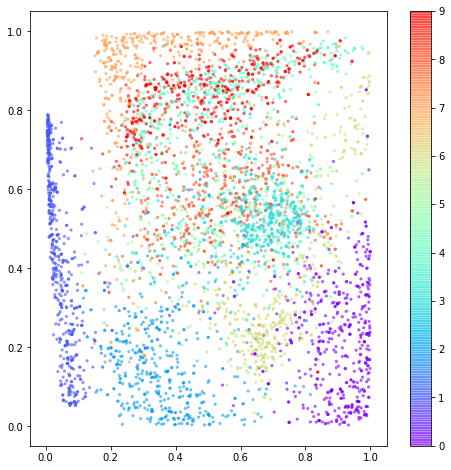

In [55]:
# color code latent points

from scipy.stats import norm

n_to_show = 5000
grid_size = 15
figsize = 8

np.random.seed(42)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]


z_points = vae_encode(model, example_images)
p_points = norm.cdf(z_points)


plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

plt.figure(figsize=(figsize, figsize))
plt.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)
plt.colorbar()

plt.show()

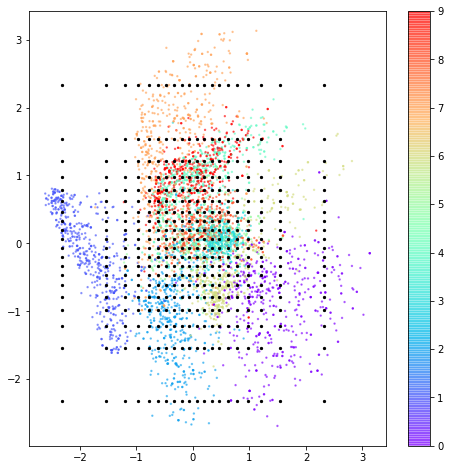

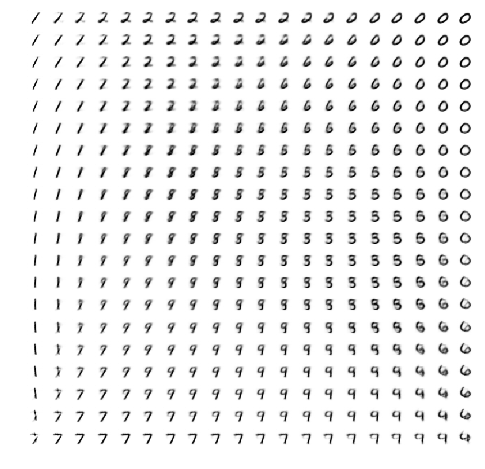

In [56]:
# Generate images from 2d grid

n_to_show = 5000 #500
grid_size = 20
figsize = 8
np.random.seed(0)

np.random.seed(42)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]
z_points = vae_encode(model, example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae_decode(model, z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)

plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
plt.show()